# Using the rate to correct timestamp

Well here is another dead attempt to correct for the timestamp. This time we will use the aggregate data from the orbit buffer to bring back the pps. We will do a test drive on the veto pack

In [2]:
# Import libraries
import src as rp
import matplotlib.pyplot as plt
import numpy as np

# Some constants
orbit_buffer_fname  = '../../Data/RAW/SD-915/Light1_2022-05-20_Buff1.dat'
veto_buffer_fname   = '../../Data/RAW/SD-915/Light1_2022-05-20_Buff7.dat'

In [4]:
# Load the buffers
orbit   = rp.get_dict(orbit_buffer_fname,rp.ORBIT_STRUCT,condition="data['id_bit'] == 1")
veto    = rp.get_dict(veto_buffer_fname, rp.VETO_STRUCT,MAX=30000,STUPID=True)

Line:   0%|          | 0/4347 [00:00<?, ?it/s]

Line:   0%|          | 0/30000 [00:00<?, ?it/s]

(<Figure size 3000x800 with 1 Axes>,
 <AxesSubplot:title={'center':'Timestamps vs event number'}>)

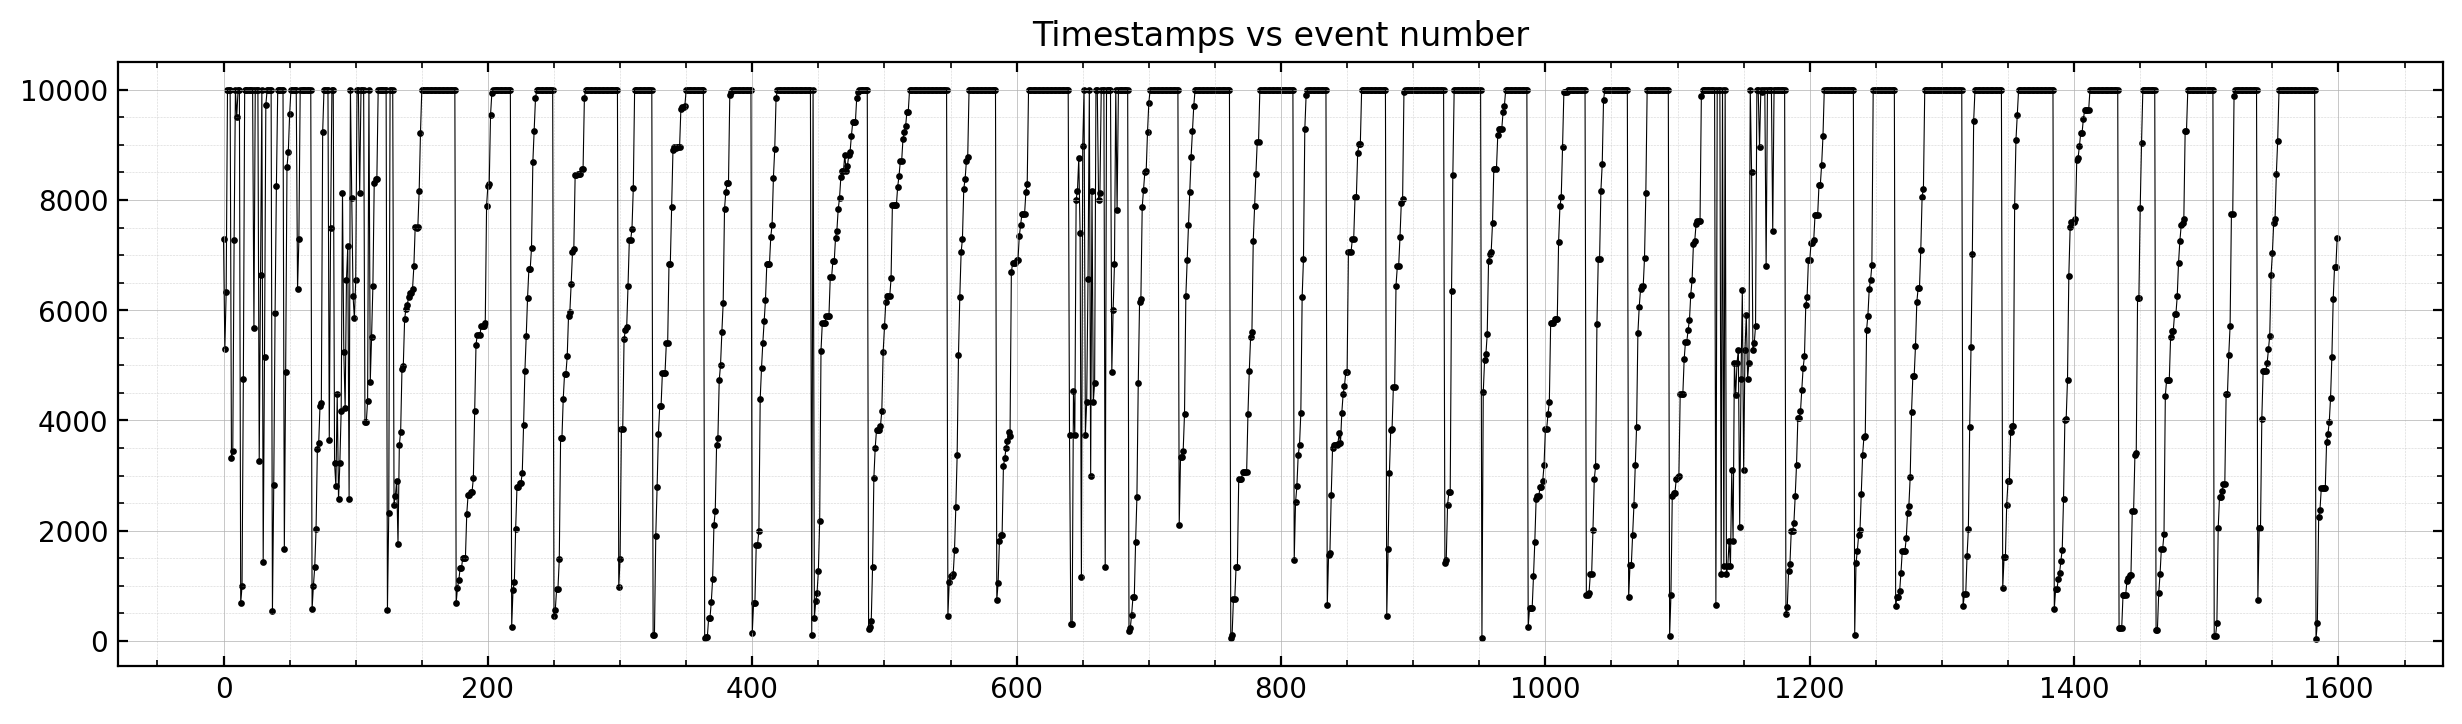

In [14]:
# Here is Some timestamps
rp.plot_timestamp(veto,rp.VETO_STRUCT,RANGE=(0,1600))

Text(0.5, 0, 'seconds')

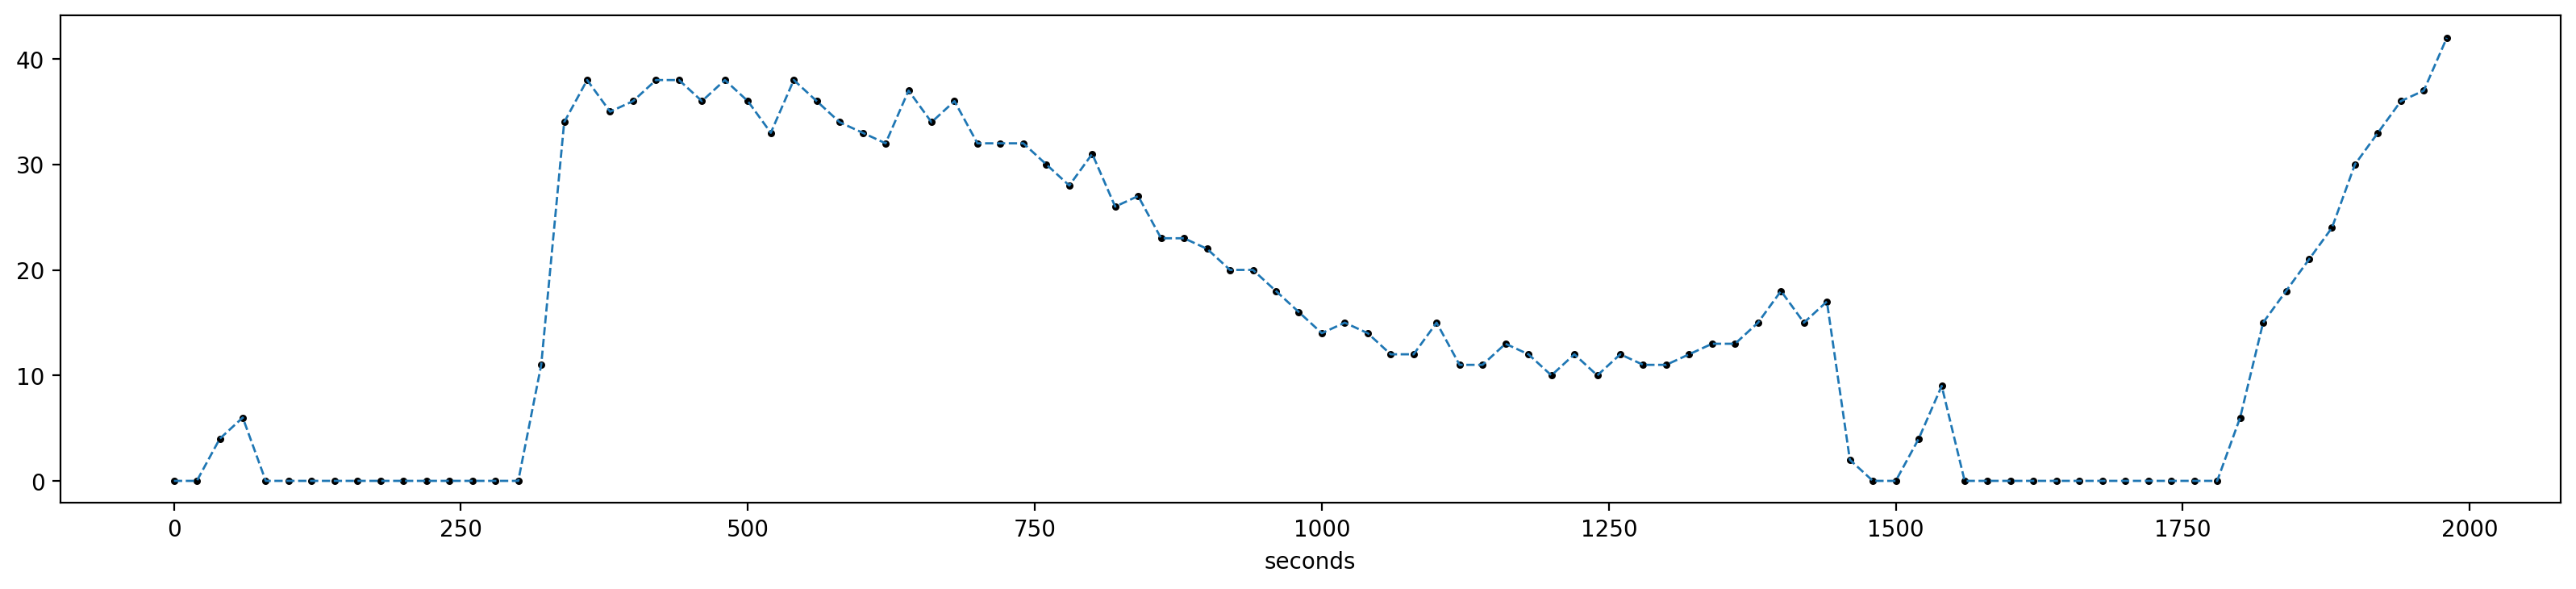

In [27]:
# Here are some rates
fig = plt.figure(figsize=(20,4),dpi=200)
ax  = fig.add_subplot(111)
x   = np.arange(100)*20
ax.plot(x,orbit['ratev'][:100],ls='--',lw=1)
ax.scatter(x,orbit['ratev'][:100],marker='o',s=5,c='k')
ax.set_xlabel('seconds')

Text(0.5, 0, 'seconds')

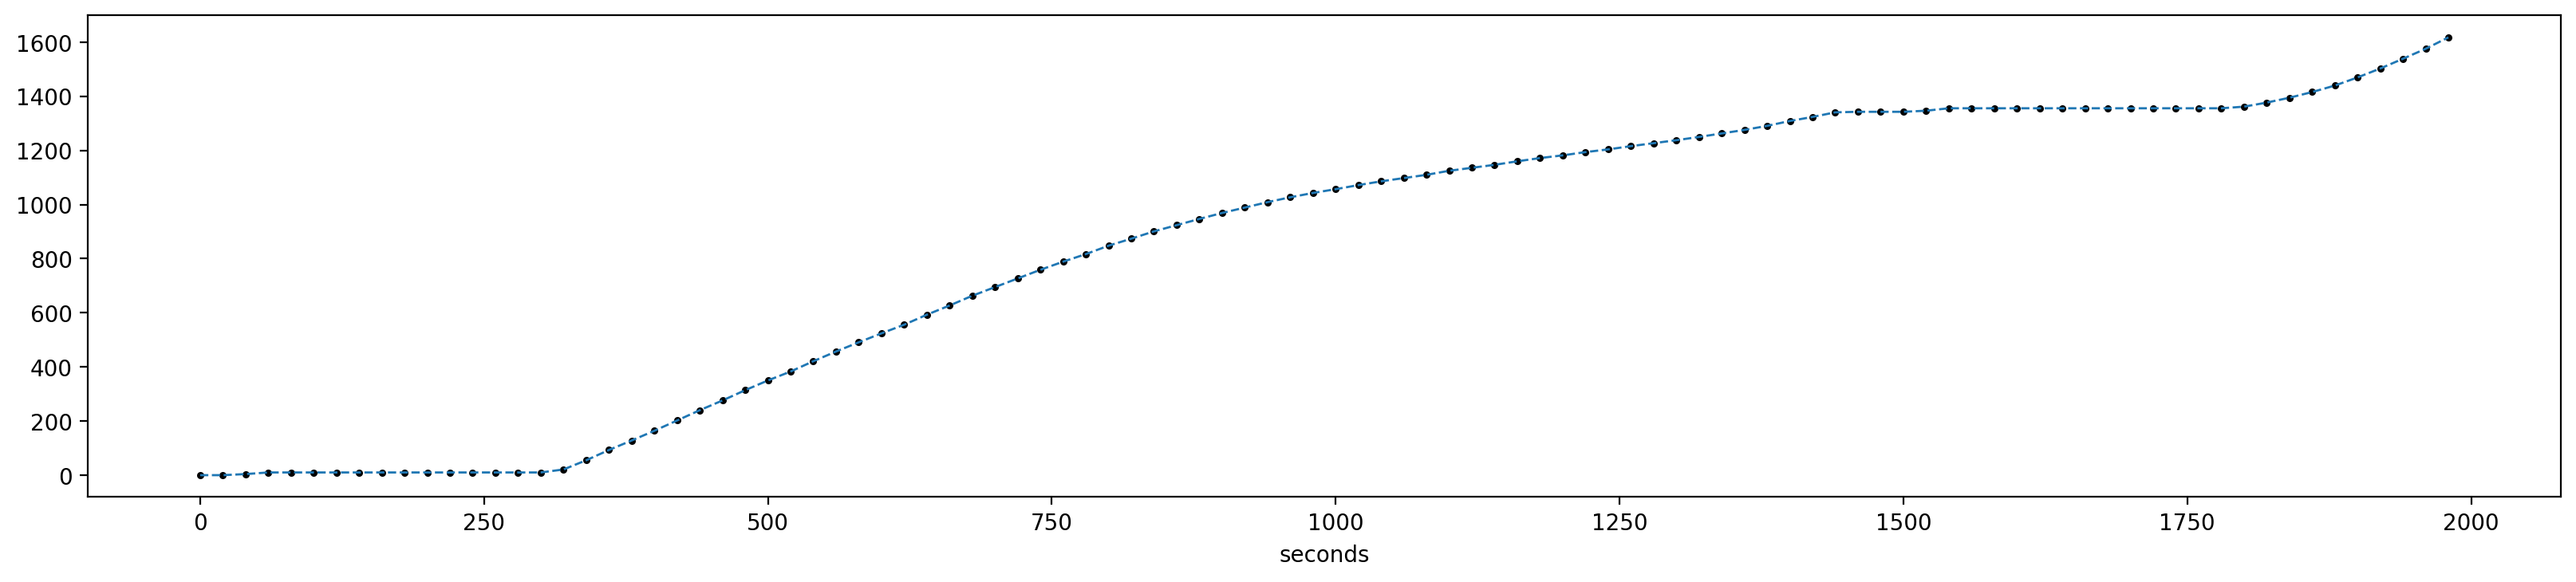

In [26]:
# Let's sum those rates
fig = plt.figure(figsize=(20,4),dpi=200)
ax  = fig.add_subplot(111)
x   = np.arange(100)*20
ax.plot(x,np.cumsum(orbit['ratev'][:100]),ls='--',lw=1)
ax.scatter(x,np.cumsum(orbit['ratev'][:100]),marker='o',s=5,c='k')
ax.set_xlabel('seconds')

In [43]:
# Now let's get some counts!
total_cnt   = 0     # Stores the total number of events
timestamp   = [0]   # New timestamp
TIME        = 20    # New time

# For each count in the orbit
for count in orbit['ratev'][:100]:
    # Get the next number of counts
    if count == 0: continue

    # Create some linspace
    for item in np.linspace(timestamp[-1],timestamp[-1] + TIME,int(count) + 1)[1:]: timestamp.append(item)
    total_cnt += count

total_cnt = int(total_cnt)

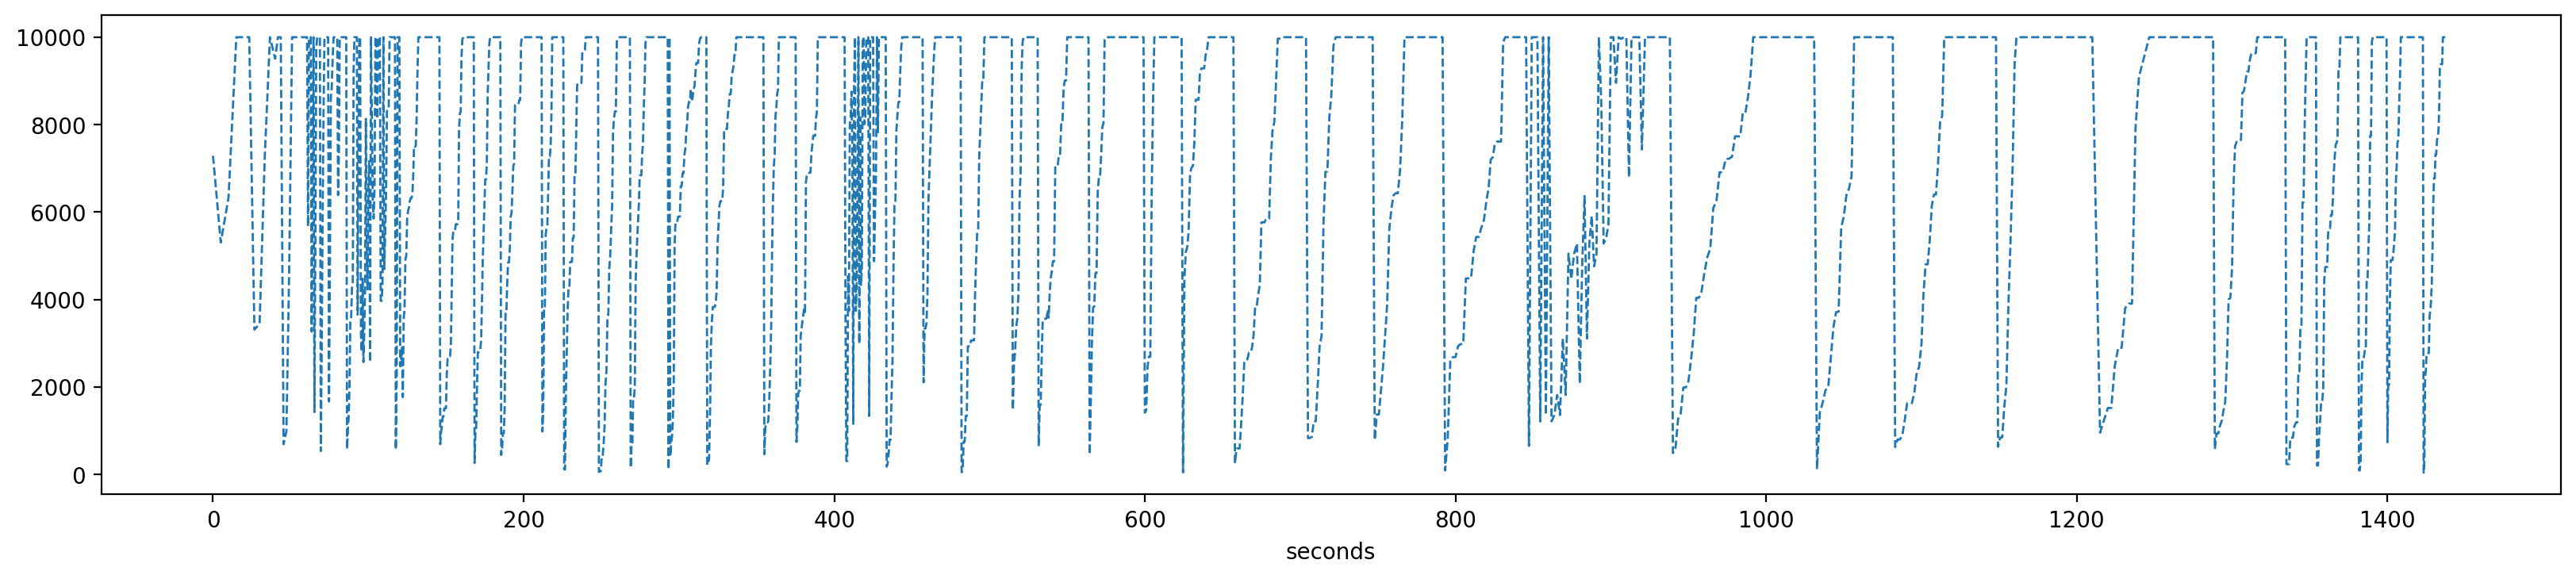

In [45]:
# Let's sum those rates
fig = plt.figure(figsize=(20,4),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('seconds')
plt.plot(timestamp[:-1],veto['stimestamp'][:total_cnt],ls='--',lw=1)

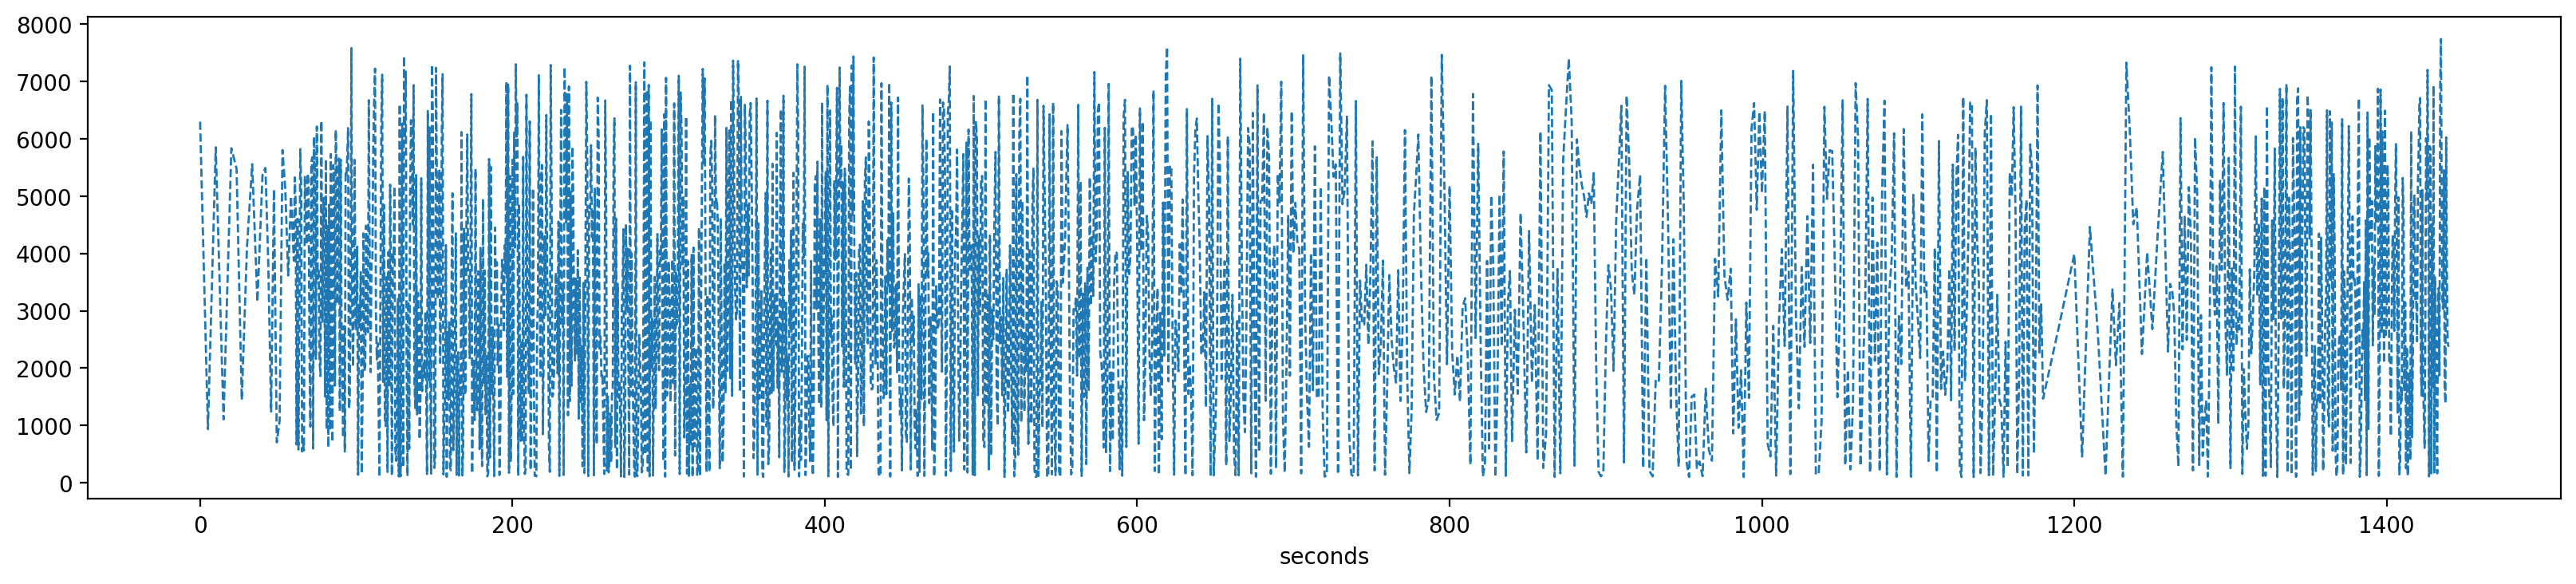

In [48]:
# Let's sum those rates
fig = plt.figure(figsize=(20,4),dpi=200)
ax  = fig.add_subplot(111)
ax.set_xlabel('seconds')
plt.plot(timestamp[:-1],veto['adc_counts'][:total_cnt],ls='--',lw=1)